In [95]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import random

from timeit import default_timer as timer 

#import functions from modular
import modular.samples_setup as cs
from modular import engine
from modular import extra_functions as ef
from modular import model_builder


#### Run base models

In [96]:
#%run /home/sofia/Candu_postdoc/Informative_ML/simulate_2_devices.py

In [97]:

model_1 = model_builder.TVGG(input_shape = 1,
                             hidden_units = 10, 
                             output_shape = 2)
model_1.load_state_dict(torch.load(f = '/home/sofia/Candu_postdoc/Informative_ML/models/model_d1.pth'))

model_2 = model_builder.TVGG(input_shape = 1,
                             hidden_units = 10, 
                             output_shape = 2)
model_2.load_state_dict(torch.load(f = '/home/sofia/Candu_postdoc/Informative_ML/models/model_d2.pth'))


/tmp/ipykernel_24409/725561154.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/tmp/ipykernel_24409/725561154.py:9: FutureWarning: You are using `torch.load` with `weights

<All keys matched successfully>

#### Set conditional probabilities and simulate label outputs:
Device1 = Device with noise

Device2 = Device with no(or less) noise



In [5]:
# Define the conditional probabilities P(D1|D2)
# Di=0 means square, and Di=0 means circle
P_D1_given_D2_1 = 1  # P(D1 = 1 | D2 = 1)
P_D1_given_D2_0 = 0  # P(D1 = 1 | D2 = 0)

# Simulate D2 values (assume a 1/2 probabilities for square and circles)
n = 10000
D2 = np.random.binomial(1, 0.5, size=n)

# Simulate D1 given D2 using the conditional probabilities
D1 = np.zeros(n)
D1[D2 == 1] = np.random.binomial(1, P_D1_given_D2_1, size=np.sum(D2 == 1))  
D1[D2 == 0] = np.random.binomial(1, P_D1_given_D2_0, size=np.sum(D2 == 0)) 



In [6]:
print(len(D1[D1 == 1])/len(D1))
print(len(D1[D1 == 0])/len(D1))


0.5013
0.4987


#### Simulate new images

In [7]:
### Simulate images:
output_D1 = cs.generate_sample(noise_prop = 1,seed = 10, var=0.35, order=D1)
images_D1, labels_D1= (output_D1['images'], output_D1['labels']) 
X = torch.from_numpy(images_D1).type(torch.float)
X = X.unsqueeze(1)  
Y = torch.from_numpy(labels_D1).type(torch.long)
D1_dataset = torch.utils.data.TensorDataset(X,Y)

output_D2 = cs.generate_sample(noise_prop = 1,seed = 10, var=0.05, order=D2)
images_D2, labels_D2= (output_D2['images'], output_D2['labels']) 
train_dataset_d2, test_dataset_d2 = cs.generate_dataset(images_D2, labels_D2)
X = torch.from_numpy(images_D2).type(torch.float)
X = X.unsqueeze(1)  
Y = torch.from_numpy(labels_D2).type(torch.long)
D2_dataset = torch.utils.data.TensorDataset(X,Y)


##### Estimate P(D2=j | D1=i)

In [8]:
P_D2_1_given_D1_1=np.sum(D2[D1 == 1])/len(D2[D1 == 1])
P_D2_1_given_D1_0=np.sum(D2[D1 == 0])/len(D2[D1 == 0])
#P_D2_0_given_D1_1=(len(D2[D1==1])-np.sum(D2[D1 == 1]))/len(D2[D1 == 1])
P_D2_0_given_D1_1 = 1-P_D2_1_given_D1_1
P_D2_0_given_D1_0 = 1-P_D2_1_given_D1_0

P_D2_given_D1 = np.array([[P_D2_0_given_D1_0, P_D2_1_given_D1_0], 
                          [P_D2_0_given_D1_1, P_D2_1_given_D1_1]])

P_D2_given_D1

array([[1., 0.],
       [0., 1.]])

#### Predict labels with pre-trained models

In [9]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc


In [10]:
import torch.nn.functional as F

d2_dataloader = DataLoader(D2_dataset,batch_size=len(D2_dataset),
                                         shuffle=False)
        
for X, y in d2_dataloader:
    y_pred = model_2(X)
    acc_value =  accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    y_preds_d2 = y_pred.argmax(dim=1)
    probas = F.softmax(y_pred, dim=1)
    probabilities_d2  = probas


acc_value 


96.61999999999999

In [11]:
d1_dataloader = DataLoader(D1_dataset,batch_size=len(D1_dataset),
                           shuffle=False)
y_d1_true = []
for X, y in d1_dataloader:
    y_d1_true.append(y.detach().numpy())
    y_pred = model_1(X)
    acc_value =  accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    probas = F.softmax(y_pred, dim=1)
    probabilities_d1 = probas

y_preds_d1 = y_pred
acc_value 

84.47

#### Adjustig predictions

In [12]:
new_predictions = []
for sample in range(len(D1_dataset)):
    d2_curr = y_preds_d2[sample]
    j = int(d2_curr)
    p_adj = []
    for i in range(2):
        a = P_D2_given_D1[i,j]*probabilities_d1[sample,i]/probabilities_d2[sample,j] 
        p_adj.append(a.detach().numpy()) 
    p_adj=np.array(p_adj)
    new_predictions.append(np.argmax(p_adj))

In [13]:
correct = (np.array(y_d1_true) == np.array(new_predictions)).sum().item()
acc = (correct / len(y_d1_true[0])) * 100 
acc


96.61999999999999

### Loop (to.py?)

In [1]:
import numpy as np
import torch 
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from timeit import default_timer as timer 

#import functions from modular
import modular.samples_setup as cs
from modular import engine
from modular import extra_functions as ef
from modular import model_builder


model_1 = model_builder.TVGG(input_shape = 1,
                             hidden_units = 10, 
                             output_shape = 2)
model_1.load_state_dict(torch.load(f = '/home/sofia/Candu_postdoc/Informative_ML/models/model_d1.pth'))

model_2 = model_builder.TVGG(input_shape = 1,
                             hidden_units = 10, 
                             output_shape = 2)
model_2.load_state_dict(torch.load(f = '/home/sofia/Candu_postdoc/Informative_ML/models/model_d2.pth'))

acc_values_d2=[]
acc_values_d1=[]
acc_values_d1_corrected=[]

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc


p_11 = [0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
p_10 = [0.95,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
n = 10000
n_iters = 10

for m1 in range(len(p_11)):
    for m2 in range(len(p_10)):
               
        ## 1. Simulate labels
        
        # Define the conditional probabilities P(D1|D2)
        # Di=0 means square, and Di=0 means circle
        P_D1_given_D2_1 = p_11[m1]  # P(D1 = 1 | D2 = 1)
        P_D1_given_D2_0 = p_10[m2]  # P(D1 = 1 | D2 = 0)
        for iter in range(n_iters):
            # Simulate D2 labels (assume a 1/2 probabilities for square and circles)
            D2 = np.random.binomial(1, 0.5, size=n)
            # Simulate D1 given D2 using the conditional probabilities
            D1 = np.zeros(n)
            D1[D2 == 1] = np.random.binomial(1, P_D1_given_D2_1, size=np.sum(D2 == 1))  
            D1[D2 == 0] = np.random.binomial(1, P_D1_given_D2_0, size=np.sum(D2 == 0))
            
            ## 2.  Simulate images:
            output_D1 = cs.generate_sample(noise_prop = 1,seed = 10, var=0.35, order=D1)
            images_D1, labels_D1= (output_D1['images'], output_D1['labels']) 
            X = torch.from_numpy(images_D1).type(torch.float)
            X = X.unsqueeze(1)  
            Y = torch.from_numpy(labels_D1).type(torch.long)
            D1_dataset = torch.utils.data.TensorDataset(X,Y)

            output_D2 = cs.generate_sample(noise_prop = 1,seed = 10, var=0.05, order=D2)
            images_D2, labels_D2= (output_D2['images'], output_D2['labels']) 
            train_dataset_d2, test_dataset_d2 = cs.generate_dataset(images_D2, labels_D2)
            X = torch.from_numpy(images_D2).type(torch.float)
            X = X.unsqueeze(1)  
            Y = torch.from_numpy(labels_D2).type(torch.long)
            D2_dataset = torch.utils.data.TensorDataset(X,Y) 
            
            ## 3. Estimate P(D2=j|D1=i)
            P_D2_1_given_D1_1=np.sum(D2[D1 == 1])/len(D2[D1 == 1])
            P_D2_1_given_D1_0=np.sum(D2[D1 == 0])/len(D2[D1 == 0])

            P_D2_0_given_D1_1 = 1-P_D2_1_given_D1_1
            P_D2_0_given_D1_0 = 1-P_D2_1_given_D1_0

            P_D2_given_D1 = np.array([[P_D2_0_given_D1_0, P_D2_1_given_D1_0], 
                                    [P_D2_0_given_D1_1, P_D2_1_given_D1_1]])
            
            ## 4. Predict labels with pre-trained models
            
            d2_dataloader = DataLoader(D2_dataset,batch_size=len(D2_dataset),
                                                    shuffle=False)
            for X, y in d2_dataloader:
                y_pred = model_2(X)
                acc_value =  accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
                y_preds_d2 = y_pred.argmax(dim=1)
                probas = F.softmax(y_pred, dim=1)
                probabilities_d2  = probas
                
            acc_values_d2.append(acc_value)
            #print(acc_value)
            
            d1_dataloader = DataLoader(D1_dataset,batch_size=len(D1_dataset),
                            shuffle=False)
            y_d1_true = []
            for X, y in d1_dataloader:
                y_d1_true.append(y.detach().numpy())
                y_pred = model_1(X)
                acc_value =  accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
                probas = F.softmax(y_pred, dim=1)
                probabilities_d1 = probas

            y_preds_d1 = y_pred
            acc_values_d1.append(acc_value) 
            #print(acc_value)
            
            # 5. Adjustig predictions
            new_predictions = []
            for sample in range(len(D1_dataset)):
                d2_curr = y_preds_d2[sample]
                j = int(d2_curr)
                p_adj = []
                for i in range(2):
                    a = P_D2_given_D1[i,j]*probabilities_d1[sample,i]/probabilities_d2[sample,j] 
                    p_adj.append(a.detach().numpy()) 
                p_adj=np.array(p_adj)
                new_predictions.append(np.argmax(p_adj))
            correct = (np.array(y_d1_true) == np.array(new_predictions)).sum().item()
            acc = (correct / len(y_d1_true[0])) * 100 
            acc_values_d1_corrected.append(acc)
            #print(acc)
    





/tmp/ipykernel_5568/2495029614.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load(f = '/home/sofia/Candu_postdoc/Informative_ML/models/m

Text(0, 0.5, 'Original test accuracy')

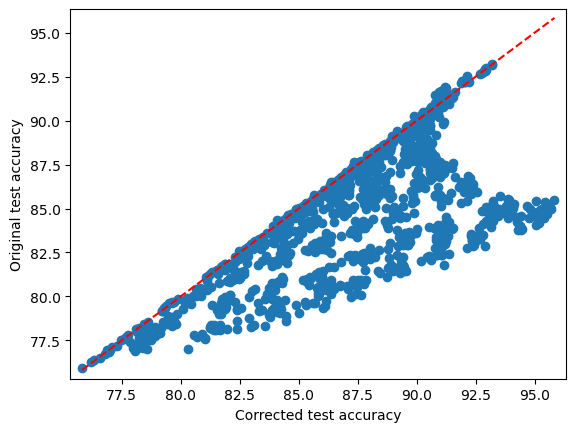

In [90]:
import matplotlib.pyplot as plt

lim_max = max(acc_values_d1_corrected + acc_values_d1)
lim_min = min(acc_values_d1_corrected + acc_values_d1)
x = np.linspace(lim_min, lim_max, 100)

plt.plot(acc_values_d1_corrected, acc_values_d1,'o')
plt.xlim(lim_min-0.5, lim_max+0.5)
plt.ylim(lim_min-0.5, lim_max+0.5)
plt.plot(x, x, label='y = x', linestyle='--', color='red')

plt.xlabel('Corrected test accuracy')
plt.ylabel('Original test accuracy')
 

In [91]:
import matplotlib.pyplot as plt
import pandas as pd
from plotnine import *


p_11s = np.repeat(p_11 ,len(p_10)*n_iters) # Check this!
p_10s = np.tile(np.repeat(p_10 ,n_iters),len(p_11))
iteration = np.tile(np.arange(1,n_iters+1,1),len(p_11)*len(p_10))

data_plot = {
    'p_11': p_11s,
    'p_10': p_10s,
    'iteration': iteration,
    'original_ta': acc_values_d1,
    'corrected_ta': acc_values_d1_corrected
}

df = pd.DataFrame(data_plot)

df['ta_diff'] = df['corrected_ta'] - df['original_ta']  
df['ta_percent'] = df['ta_diff'] / df['original_ta']  
df['p_00'] = np.round(1-df['p_10'],2)


In [92]:
#summary_df = df.groupby(['iteration','p_11','p_10']).quantile([0.25,0.5,0.75]).unstack()
summary_df = df.groupby(['p_10','p_11',]).agg(
    corrected_q25 = ('corrected_ta', lambda x: x.quantile(0.25)),
    corrected_median = ('corrected_ta', lambda x: x.quantile(0.5)),
    corrected_q75 = ('corrected_ta', lambda x: x.quantile(0.75)),
    
    original_q25 = ('original_ta', lambda x: x.quantile(0.25)),
    original_median = ('original_ta', lambda x: x.quantile(0.5)),
    original_q75 = ('original_ta', lambda x: x.quantile(0.75)),
    
    
).reset_index()



summary_df['diff_median'] = (summary_df['corrected_median'] - summary_df['original_median'])
summary_df['diff_q25'] = summary_df['corrected_q25'] - summary_df['original_q25']   
summary_df['diff_q75'] = summary_df['corrected_q75'] - summary_df['original_q75']   
summary_df['p_00'] = 1-summary_df['p_10']



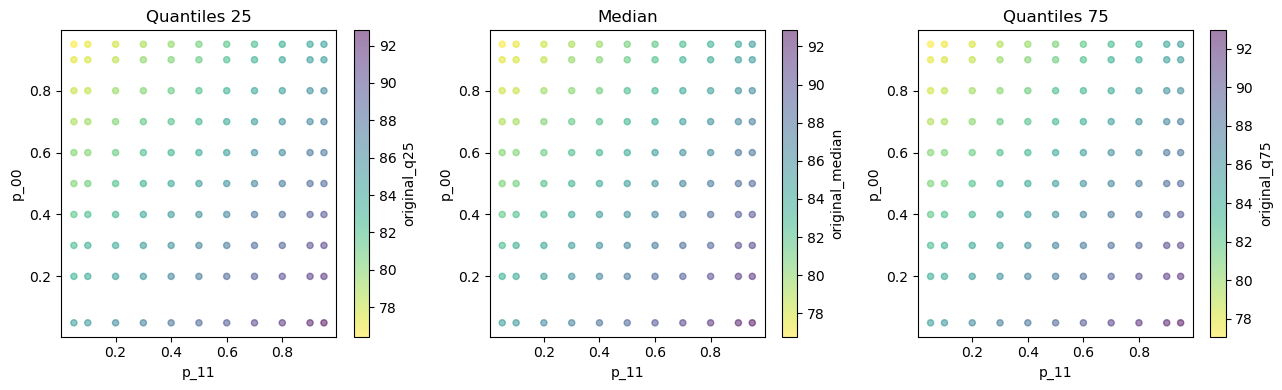

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(13,4))
axes = axes.flatten()

summary_df.plot.scatter( y="p_00", x="p_11", alpha=0.5,c='original_q25',colormap='viridis_r',ax=axes[0])
axes[0].set_title('Quantiles 25')


summary_df.plot.scatter( y="p_00", x="p_11", alpha=0.5,c='original_median',colormap='viridis_r',ax=axes[1])
axes[1].set_title('Median')


summary_df.plot.scatter( y="p_00", x="p_11", alpha=0.5,c='original_q75',colormap='viridis_r',ax=axes[2])
axes[2].set_title('Quantiles 75')


plt.tight_layout()

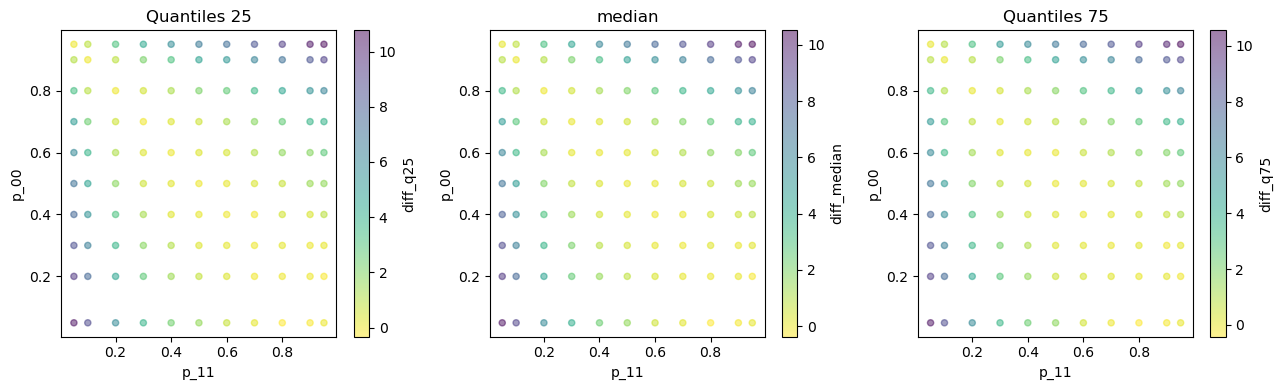

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(13,4))
axes = axes.flatten()

summary_df.plot.scatter( y="p_00", x="p_11", alpha=0.5,c='diff_q25',colormap='viridis_r',ax=axes[0])
axes[0].set_title('Quantiles 25')

summary_df.plot.scatter( y="p_00", x="p_11", alpha=0.5,c='diff_median',colormap='viridis_r',ax=axes[1])
axes[1].set_title('median')

summary_df.plot.scatter( y="p_00", x="p_11", alpha=0.5,c='diff_q75',colormap='viridis_r',ax=axes[2])
axes[2].set_title('Quantiles 75')

plt.tight_layout()


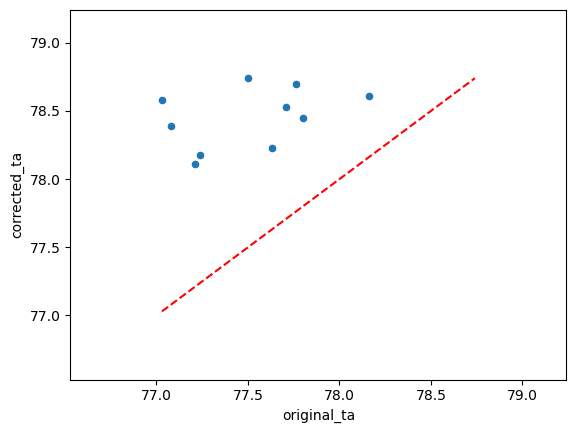

In [87]:
p_11_f =  0.05
p_00_f =  0.9

df_filter = df[(df['p_11'] == p_11_f ) & (df['p_00'] == p_00_f)]

lim_max = max(max(df_filter['original_ta']) ,max(df_filter['corrected_ta']))
lim_min = min(min(df_filter['original_ta'] ), min(df_filter['corrected_ta']))
x = np.linspace(lim_min, lim_max, 100)

df_filter.plot.scatter(x='original_ta' ,y='corrected_ta')
plt.xlim(lim_min-0.5, lim_max+0.5)
plt.ylim(lim_min-0.5, lim_max+0.5)
plt.plot(x, x, label='y = x', linestyle='--', color='red')


